<a href="https://colab.research.google.com/github/Zelechos/IA_Code/blob/master/SegundoParcial%20IA/Ejercicio1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9675 sha256=1eef8ee69196f7e1f6c42a5bb20edcdf34fe1d1a47ce0259b1e555c17b9583ed
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import wget 

wget.download('http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar')

'images.tar'

In [ ]:
import shutil

shutil.unpack_archive("/content/images.tar", "/content")

In [2]:
import os 
PATH = '/content/test'
os.mkdir(PATH)

In [31]:
import os 

PATH = '/content/Images'

classes = os.listdir(PATH)
classes[115:]

['n02106166-Border_collie',
 'n02102480-Sussex_spaniel',
 'n02085782-Japanese_spaniel',
 'n02093991-Irish_terrier',
 'n02097130-giant_schnauzer']

In [33]:
imgs, labels = [], []

for i, lab in enumerate(classes[115:]):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

print(len(imgs))

Categoría: n02106166-Border_collie. Imágenes: 150
Categoría: n02102480-Sussex_spaniel. Imágenes: 151
Categoría: n02085782-Japanese_spaniel. Imágenes: 185
Categoría: n02093991-Irish_terrier. Imágenes: 169
Categoría: n02097130-giant_schnauzer. Imágenes: 157
812


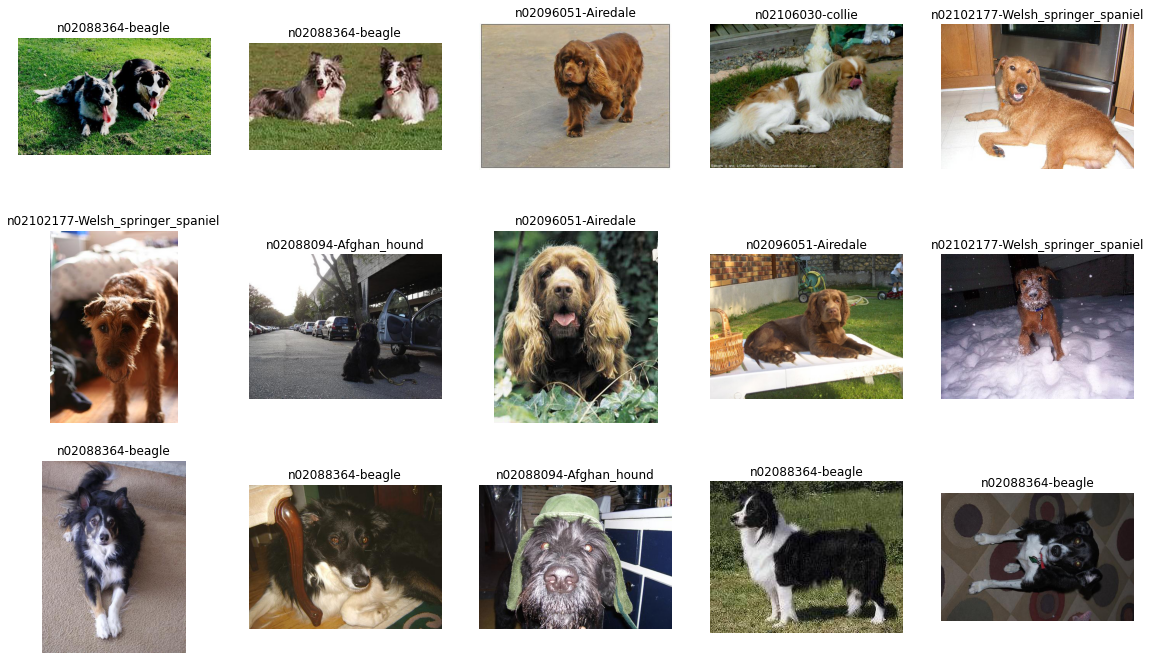

In [34]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10*2,6*2))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

In [35]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(649, 163)

In [36]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

cuda


In [37]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device), 
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(649, 163)

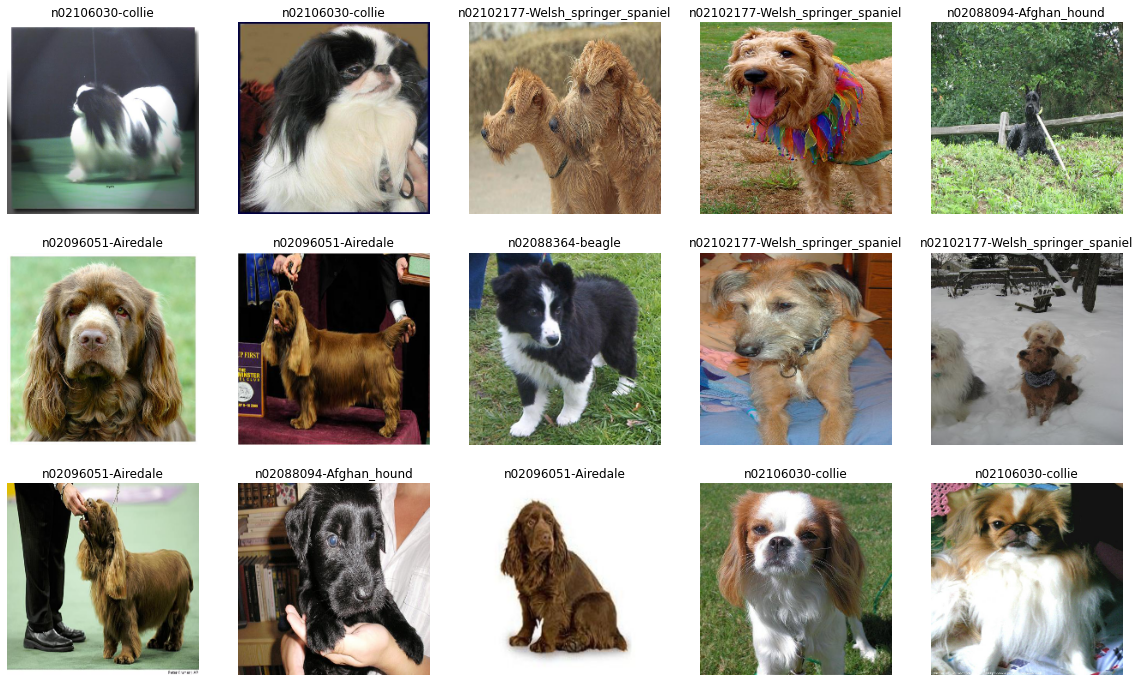

In [38]:
fig, axs = plt.subplots(3,5, figsize=(10*2,6*2))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [39]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

In [40]:
import torchvision

resnet = torchvision.models.resnet34()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512,5)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [42]:
model = Model()
outputs = model(torch.randn(64, 3, 224, 224))
outputs.shape

torch.Size([64, 5])

In [43]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [44]:
model = Model()
fit(model, dataloader, epochs=10)


loss 1.59224 acc 0.26057: 100%|██████████| 11/11 [00:05<00:00,  2.07it/s]

val_loss 1.65247 val_acc 0.22699: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/10 loss 1.59224 val_loss 1.65247 acc 0.26057 val_acc 0.22699



loss 1.54008 acc 0.34438: 100%|██████████| 11/11 [00:04<00:00,  2.23it/s]

val_loss 1.67510 val_acc 0.26994: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/10 loss 1.54008 val_loss 1.67510 acc 0.34438 val_acc 0.26994



loss 1.46253 acc 0.40388: 100%|██████████| 11/11 [00:04<00:00,  2.23it/s]

val_loss 1.84395 val_acc 0.25153: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/10 loss 1.46253 val_loss 1.84395 acc 0.40388 val_acc 0.25153



loss 1.40681 acc 0.41525: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]

val_loss 1.51775 val_acc 0.31902: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/10 loss 1.40681 val_loss 1.51775 acc 0.41525 val_acc 0.31902



loss 1.30104 acc 0.48090: 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]

val_loss 1.49281 val_acc 0.36196: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5/10 loss 1.30104 val_loss 1.49281 acc 0.48090 val_acc 0.36196



loss 1.21844 acc 0.51626: 100%|██████████| 11/11 [00:04<00:00,  2.22it/s]

val_loss 1.65227 val_acc 0.34356: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6/10 loss 1.21844 val_loss 1.65227 acc 0.51626 val_acc 0.34356



loss 1.18818 acc 0.50079: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]

val_loss 1.90754 val_acc 0.26380: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7/10 loss 1.18818 val_loss 1.90754 acc 0.50079 val_acc 0.26380



loss 1.11304 acc 0.54198: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]

val_loss 1.43270 val_acc 0.35583: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8/10 loss 1.11304 val_loss 1.43270 acc 0.54198 val_acc 0.35583



loss 1.10244 acc 0.58902: 100%|██████████| 11/11 [00:04<00:00,  2.22it/s]

val_loss 7.01939 val_acc 0.18405: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9/10 loss 1.10244 val_loss 7.01939 acc 0.58902 val_acc 0.18405



loss 1.05373 acc 0.58176: 100%|██████████| 11/11 [00:04<00:00,  2.20it/s]

val_loss 1.58134 val_acc 0.34356: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

Epoch 10/10 loss 1.05373 val_loss 1.58134 acc 0.58176 val_acc 0.34356


In [45]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



  0%|          | 0/11 [00:00<?, ?it/s]


loss 1.26971 acc 0.55256: 100%|██████████| 11/11 [00:03<00:00,  2.80it/s]

val_loss 0.96991 val_acc 0.75460: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/5 loss 1.26971 val_loss 0.96991 acc 0.55256 val_acc 0.75460



loss 0.69049 acc 0.88905: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s]

val_loss 0.54750 val_acc 0.90184: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/5 loss 0.69049 val_loss 0.54750 acc 0.88905 val_acc 0.90184



loss 0.45707 acc 0.95455: 100%|██████████| 11/11 [00:03<00:00,  2.84it/s]

val_loss 0.36841 val_acc 0.97546: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/5 loss 0.45707 val_loss 0.36841 acc 0.95455 val_acc 0.97546



loss 0.36527 acc 0.96149: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]

val_loss 0.32165 val_acc 0.95706: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/5 loss 0.36527 val_loss 0.32165 acc 0.96149 val_acc 0.95706



loss 0.28854 acc 0.96007: 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]

val_loss 0.23833 val_acc 0.96319: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

Epoch 5/5 loss 0.28854 val_loss 0.23833 acc 0.96007 val_acc 0.96319


In [46]:
model = Model(pretrained=True, freeze=False)
fit(model, dataloader)


loss 1.08062 acc 0.67314: 100%|██████████| 11/11 [00:05<00:00,  2.18it/s]

val_loss 0.73520 val_acc 0.82209: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/5 loss 1.08062 val_loss 0.73520 acc 0.67314 val_acc 0.82209



loss 0.40465 acc 0.95597: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]

val_loss 0.30847 val_acc 0.96319: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/5 loss 0.40465 val_loss 0.30847 acc 0.95597 val_acc 0.96319



loss 0.24671 acc 0.97711: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]

val_loss 0.21168 val_acc 0.96319: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/5 loss 0.24671 val_loss 0.21168 acc 0.97711 val_acc 0.96319



loss 0.17945 acc 0.98138: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]

val_loss 0.14746 val_acc 0.97546: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/5 loss 0.17945 val_loss 0.14746 acc 0.98138 val_acc 0.97546



loss 0.11121 acc 0.99432: 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]

val_loss 0.12722 val_acc 0.97546: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

Epoch 5/5 loss 0.11121 val_loss 0.12722 acc 0.99432 val_acc 0.97546


In [47]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)
model.unfreeze()
fit(model, dataloader, lr=1e-4)


loss 1.35511 acc 0.49858: 100%|██████████| 11/11 [00:04<00:00,  2.73it/s]

val_loss 1.10172 val_acc 0.55828: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/5 loss 1.35511 val_loss 1.10172 acc 0.49858 val_acc 0.55828



loss 0.69662 acc 0.89773: 100%|██████████| 11/11 [00:03<00:00,  2.89it/s]

val_loss 0.62299 val_acc 0.84049: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/5 loss 0.69662 val_loss 0.62299 acc 0.89773 val_acc 0.84049



loss 0.47373 acc 0.95739: 100%|██████████| 11/11 [00:03<00:00,  2.87it/s]

val_loss 0.37996 val_acc 0.97546: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/5 loss 0.47373 val_loss 0.37996 acc 0.95739 val_acc 0.97546



loss 0.35395 acc 0.95723: 100%|██████████| 11/11 [00:03<00:00,  2.85it/s]

val_loss 0.28847 val_acc 0.96319: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/5 loss 0.35395 val_loss 0.28847 acc 0.95723 val_acc 0.96319



loss 0.28224 acc 0.97585: 100%|██████████| 11/11 [00:03<00:00,  2.86it/s]

val_loss 0.22472 val_acc 0.98773: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5/5 loss 0.28224 val_loss 0.22472 acc 0.97585 val_acc 0.98773



loss 0.25527 acc 0.97301: 100%|██████████| 11/11 [00:04<00:00,  2.20it/s]

val_loss 0.22258 val_acc 0.98773: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/5 loss 0.25527 val_loss 0.22258 acc 0.97301 val_acc 0.98773



loss 0.27605 acc 0.98011: 100%|██████████| 11/11 [00:05<00:00,  2.18it/s]

val_loss 0.22090 val_acc 0.98773: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/5 loss 0.27605 val_loss 0.22090 acc 0.98011 val_acc 0.98773



loss 0.27112 acc 0.95849: 100%|██████████| 11/11 [00:05<00:00,  2.18it/s]

val_loss 0.22205 val_acc 0.98773: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/5 loss 0.27112 val_loss 0.22205 acc 0.95849 val_acc 0.98773



loss 0.24241 acc 0.97159: 100%|██████████| 11/11 [00:05<00:00,  2.18it/s]

val_loss 0.22398 val_acc 0.98773: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/5 loss 0.24241 val_loss 0.22398 acc 0.97159 val_acc 0.98773



loss 0.26070 acc 0.97727: 100%|██████████| 11/11 [00:05<00:00,  2.19it/s]

val_loss 0.22834 val_acc 0.98773: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

Epoch 5/5 loss 0.26070 val_loss 0.22834 acc 0.97727 val_acc 0.98773


In [49]:
optimizer = torch.optim.Adam([
    {'params': model.resnet.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])